In [1]:
# %%
# open a file as csv without header

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,natsort
import argparse

plt.rc('axes', labelsize=80)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=70)    # fontsize of the tick labels
plt.rc('ytick', labelsize=70)    # fontsize of the tick labels
plt.rc('legend', fontsize=60)    # legend fontsize

figsize = (50,25)

In [2]:
# target_dir = '/mydata/pytorch_custom_log_one_epoch_imagenet_dataset'
target_dir = '/home/hice1/mrao70/scratch/special_problems/results'


In [3]:
def preprocessing_time_summary(target_dir,sort_by='batch_id',fig_size=(50,25),remove_outliers=True,fig_prefix='',fig_dir=''):
    
    root_to_files = {}
    for root, dirs, files in os.walk(target_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))

    batch_to_summary= {'avg': {}, 'std': {}, 'min': {}, 'max': {}, 'median': {}, '25th': {}, '75th': {}, '75th-25th': {}}

    for root in roots:
        if 'e2e' in root:
            continue
        print(root)
        files = root_to_files[root]
        plot_df = pd.DataFrame()
        
        for file in files:
            if "worker_pid" not in file:
                continue

            df = pd.read_csv(os.path.join(root, file)
                            , header=None)

            # add header
            df.columns = ['name','start_ts','duration']

            # names that start with 'SBatchPreprocessed'
            df = df[df['name'].str.startswith('SBatchPreprocessed')]
            # map 'SBatchPreprocessed_' such that 'SBatchPreprocessed_idx' becomes 'idx' where idx is an integer
            df['batch_id'] = df['name'].map(lambda x: int(x.replace('SBatchPreprocessed_','')))


            # divide by 1000000 to convert from nanoseconds to milliseconds
            df['duration'] = df['duration']/1000000

            # concatentate all dataframes
            plot_df = pd.concat([plot_df, df])
        
        if plot_df.empty:
            continue
        def remove_wild_outliers(plot_df):
            q1 = plot_df['duration'].quantile(0.25)
            q3 = plot_df['duration'].quantile(0.75)
            iqr = (q3 - q1) * 2

            # remove outliers less than q1 - iqr only (these are numbers from last batch which has
            #  elements less than batch size because elements in a dataset may not be a multiple of batch size)
            print("remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2")
            plot_df = plot_df[~(plot_df['duration'] < (q1 - iqr))]
            return plot_df
        label = root.split('/')[-1] # retrieves b128_gpu4 kind of label
        print(f'{label}:')
        # remove outliers
        if remove_outliers:
            plot_df = remove_wild_outliers(plot_df)
          
        
        mean = np.mean(plot_df["duration"])
        std = np.std(plot_df["duration"])
        # total_preprocessing_time = np.sum(plot_df["duration"])
        quartile_diff = np.percentile(plot_df['duration'], 75) - np.percentile(plot_df['duration'], 25)

        batch_to_summary['avg'][label] = mean
        batch_to_summary['std'][label] = std
        batch_to_summary['min'][label] = plot_df["duration"].min()
        batch_to_summary['max'][label] = plot_df["duration"].max()
        batch_to_summary['median'][label] = np.median(plot_df["duration"])
        batch_to_summary['25th'][label] = np.percentile(plot_df["duration"], 25)
        batch_to_summary['75th'][label] = np.percentile(plot_df["duration"], 75)
        batch_to_summary['75th-25th'][label] = quartile_diff


    return batch_to_summary


In [4]:
batch_to_summary = preprocessing_time_summary(target_dir)

/mydata/pytorch_custom_log_one_epoch_imagenet_dataset
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b128_gpu1
b128_gpu1:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b128_gpu2
b128_gpu2:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b128_gpu3
b128_gpu3:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b128_gpu4
b128_gpu4:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b256_gpu1
b256_gpu1:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b256_gpu2
b256_gpu2:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b256_gpu3
b256_gpu3:
remove outliers less than q1 - iqr, where iqr = (

In [5]:
# print 25th and 75th percentile
print("25th percentile:")
for k,v in batch_to_summary['25th'].items():
    print(f'{k}: {v}')
print("50th percentile:")
for k,v in batch_to_summary['median'].items():
    print(f'{k}: {v}')
print("75th percentile:")
for k,v in batch_to_summary['75th'].items():
    print(f'{k}: {v}')

25th percentile:
b128_gpu1: 823.273123
b128_gpu2: 824.298999
b128_gpu3: 820.580706
b128_gpu4: 816.47771
b256_gpu1: 1668.75401025
b256_gpu2: 1638.68305875
b256_gpu3: 1649.3043315
b256_gpu4: 1654.96186825
b512_gpu1: 3311.46629625
b512_gpu2: 3317.611725
b512_gpu3: 3346.99717975
b512_gpu4: 3394.49890425
b1024_gpu2: 6704.170157500001
b1024_gpu3: 6818.237242499999
b1024_gpu4: 6967.068745500001
50th percentile:
b128_gpu1: 872.615106
b128_gpu2: 866.421621
b128_gpu3: 859.802898
b128_gpu4: 854.444355
b256_gpu1: 1743.9251055
b256_gpu2: 1715.4543775
b256_gpu3: 1718.9308965
b256_gpu4: 1723.5929554999998
b512_gpu1: 3448.6507165000003
b512_gpu2: 3444.4869015
b512_gpu3: 3472.2006835
b512_gpu4: 3528.243837
b1024_gpu2: 6937.617113
b1024_gpu3: 7026.807852
b1024_gpu4: 7239.046827
75th percentile:
b128_gpu1: 929.596615
b128_gpu2: 921.511064
b128_gpu3: 913.228661
b128_gpu4: 909.543537
b256_gpu1: 1828.358394
b256_gpu2: 1797.6606625
b256_gpu3: 1796.902415
b256_gpu4: 1816.97081
b512_gpu1: 3598.6053110000003
b5

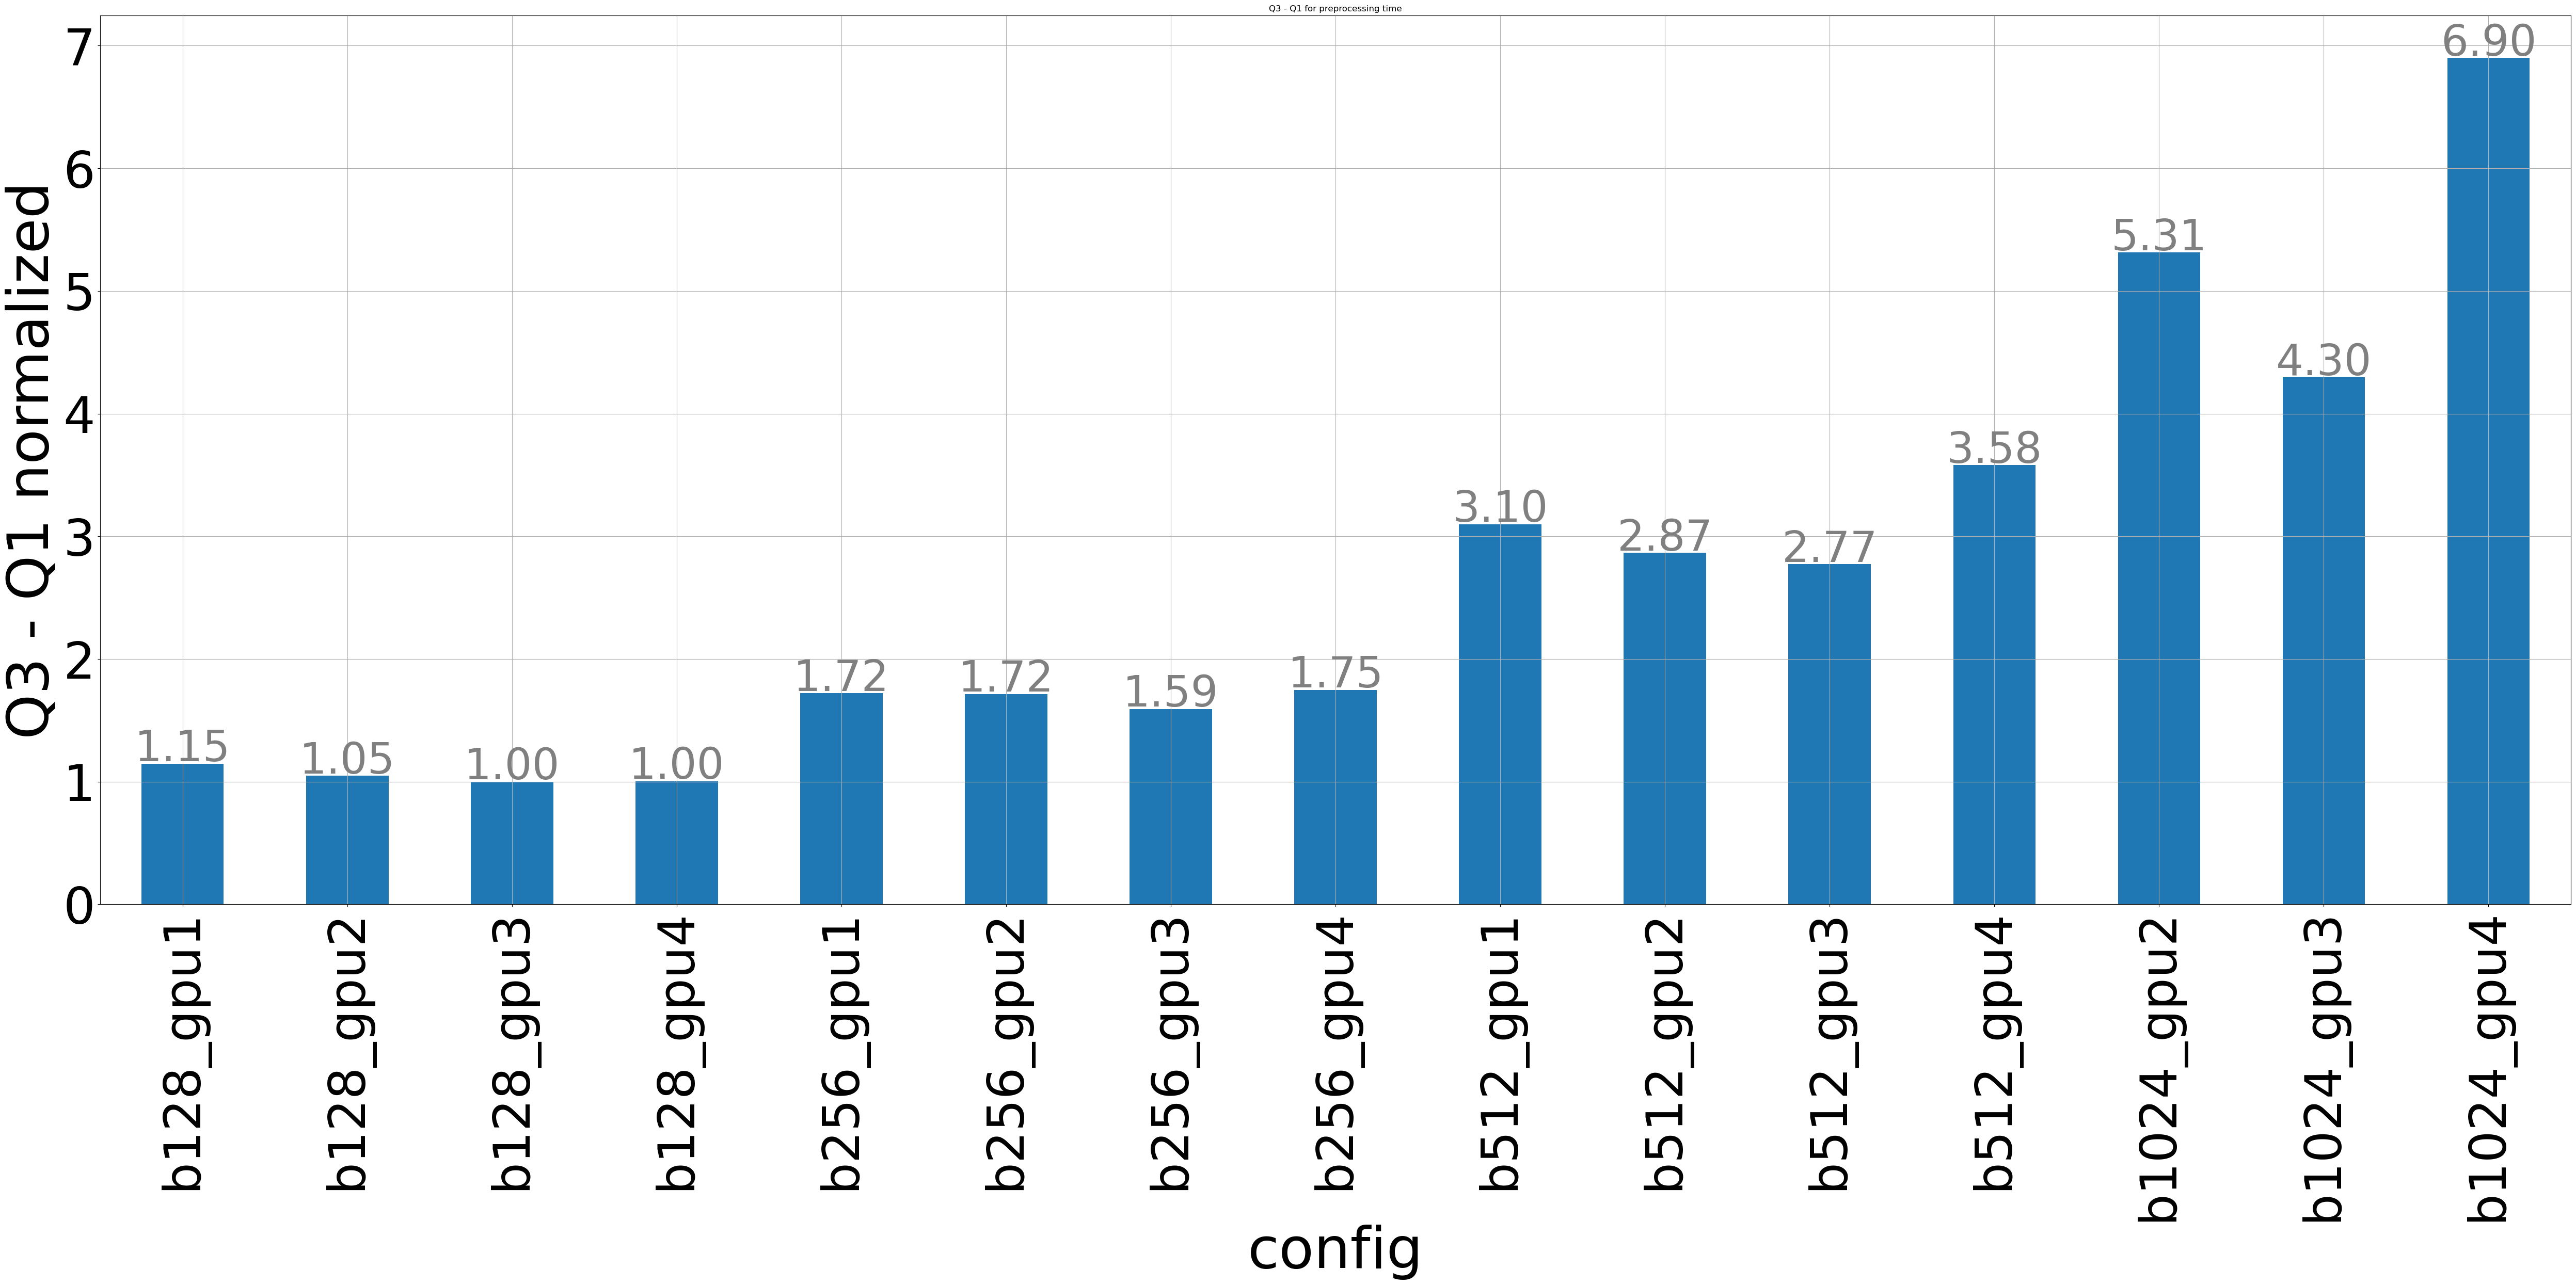

In [6]:
quartile_diff = batch_to_summary['75th-25th']
quartile_diff = pd.DataFrame.from_dict(quartile_diff, orient='index', columns=['quartile_diff'])
quartile_diff.head()
# normalize quartile_diff wrt to smallest quartile_diff
quartile_diff['quartile_diff_normalized'] = quartile_diff['quartile_diff']/quartile_diff['quartile_diff'].min()
# plot
fig, ax = plt.subplots(figsize=(50,25))
quartile_diff['quartile_diff_normalized'].plot(kind='bar', ax=ax)
# put numbers on top of bars

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=60, color='gray', xytext=(0, 20),
                textcoords='offset points')

ax.set_xlabel('config')
ax.set_ylabel('Q3 - Q1 normalized')
ax.set_title('Q3 - Q1 for preprocessing time')
ax.grid(True)
fig.tight_layout()

plt.show()

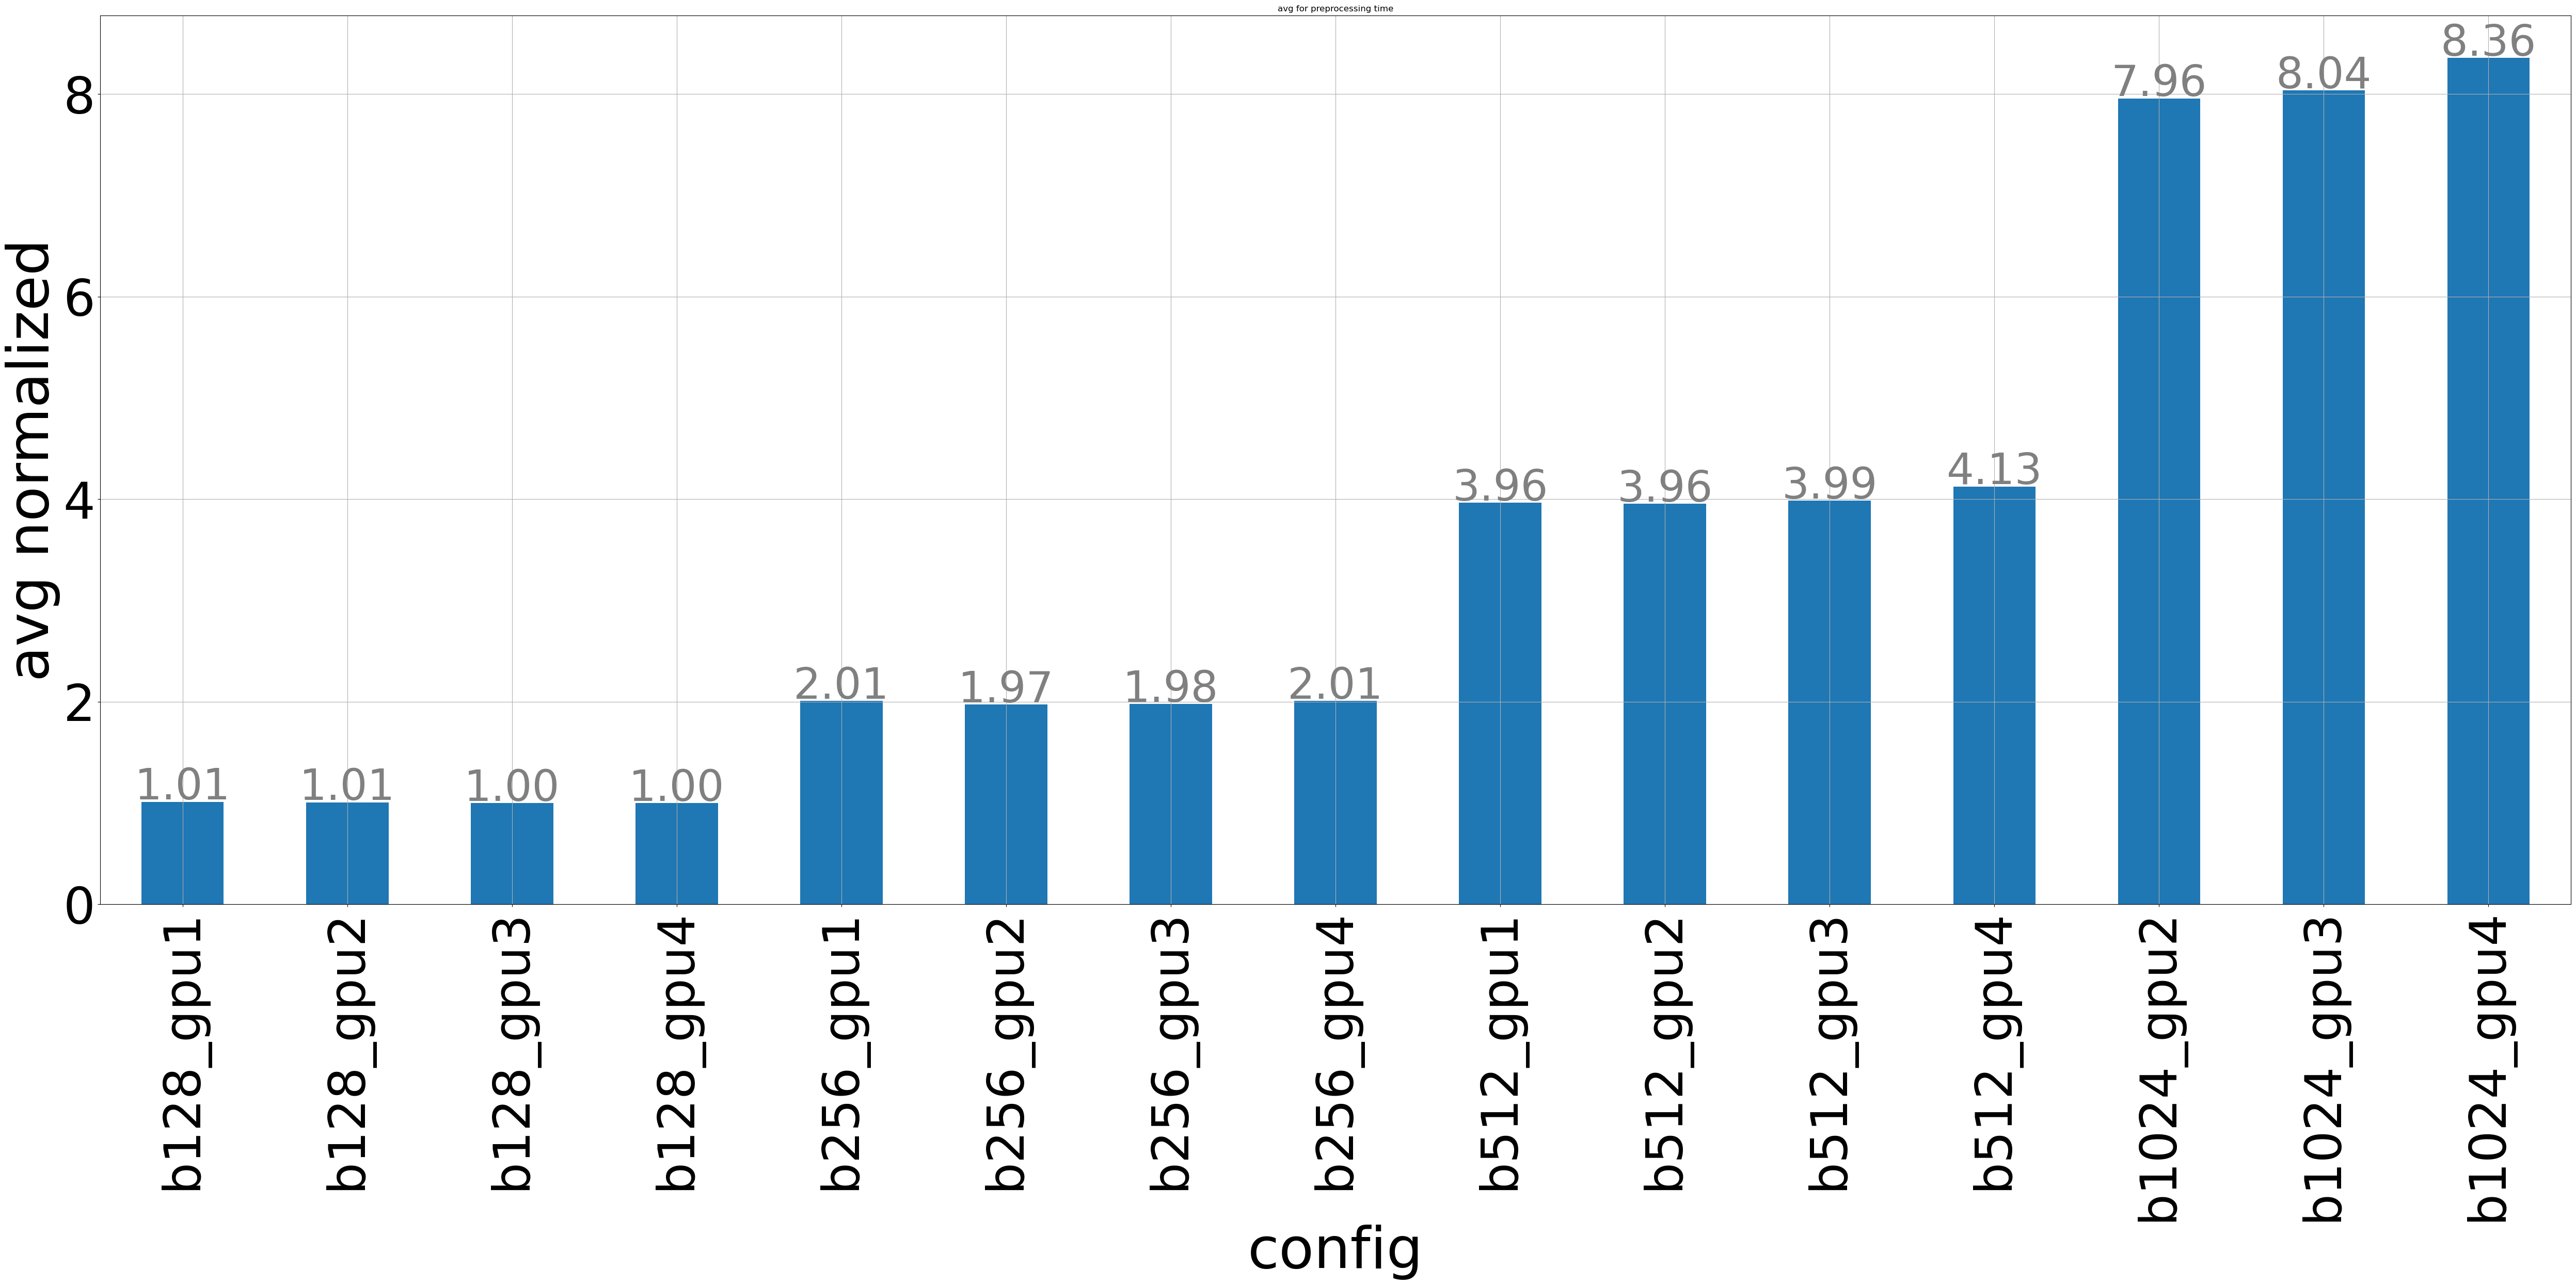

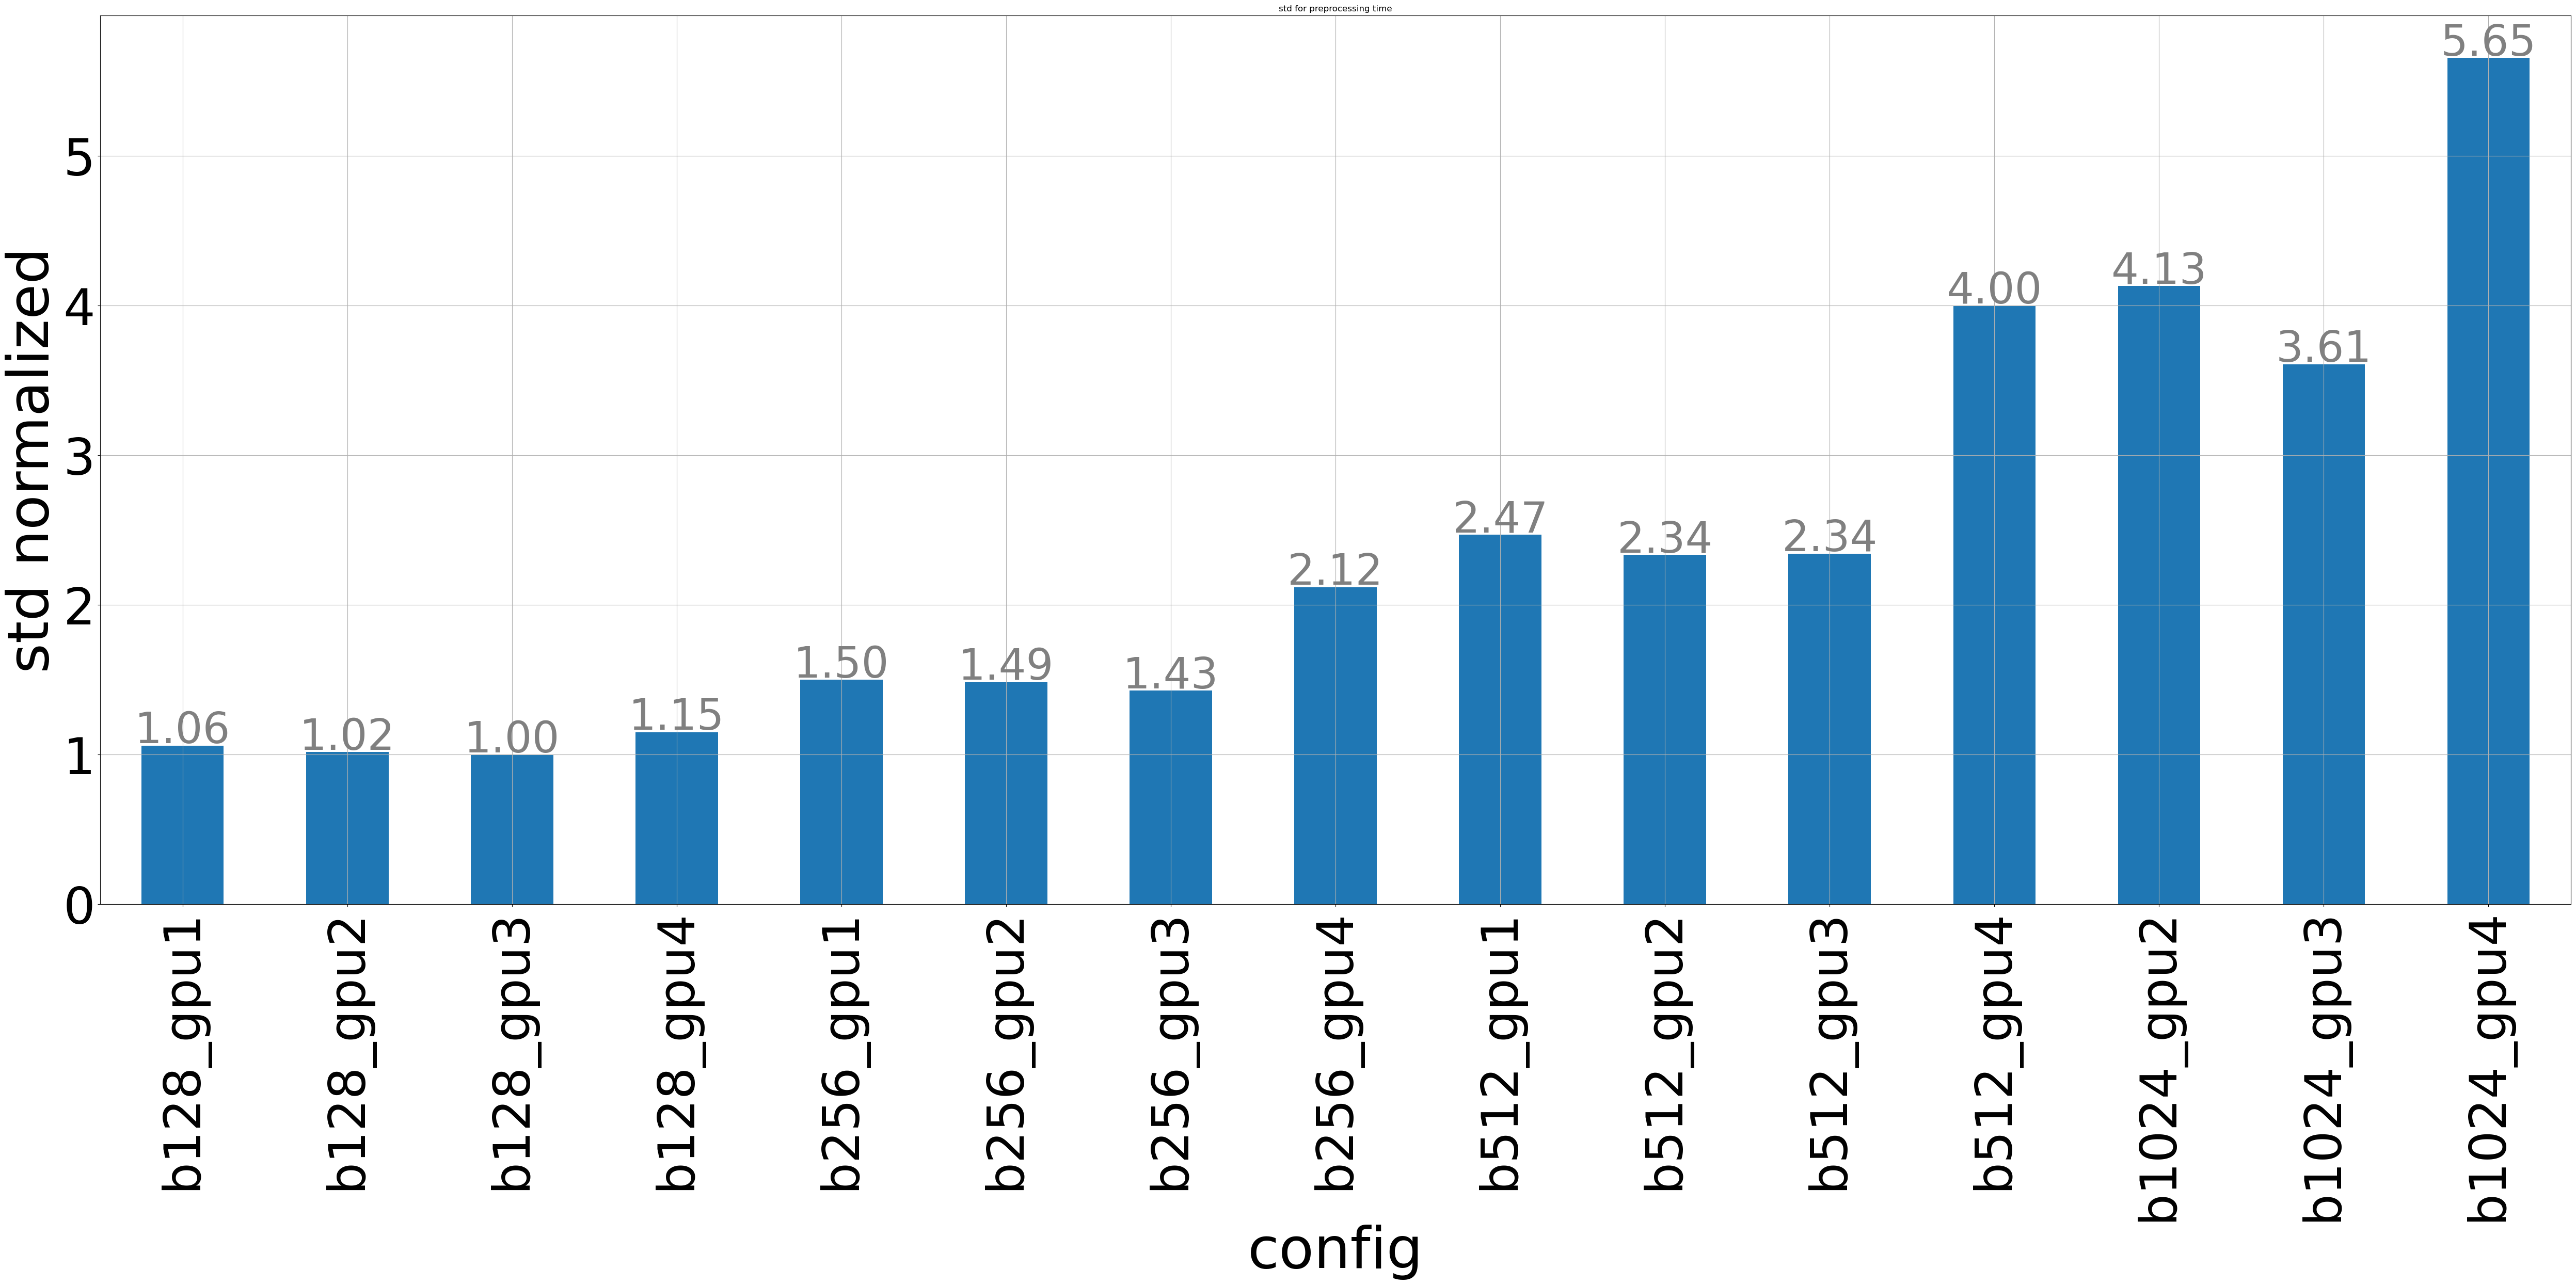

In [7]:
# do the same for avg and std
avg = batch_to_summary['avg']
std = batch_to_summary['std']

avg = pd.DataFrame.from_dict(avg, orient='index', columns=['avg'])
std = pd.DataFrame.from_dict(std, orient='index', columns=['std'])

avg['avg_normalized'] = avg['avg']/avg['avg'].min()
std['std_normalized'] = std['std']/std['std'].min()

fig, ax = plt.subplots(figsize=(50,25))
avg['avg_normalized'].plot(kind='bar', ax=ax)
# put numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=60, color='gray', xytext=(0, 20),
                textcoords='offset points')
    
ax.set_xlabel('config')
ax.set_ylabel('avg normalized')
ax.set_title('avg for preprocessing time')
ax.grid(True)
fig.tight_layout()

plt.show()

fig, ax = plt.subplots(figsize=(50,25))
std['std_normalized'].plot(kind='bar', ax=ax)
# put numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=60, color='gray', xytext=(0, 20),
                textcoords='offset points')
    
ax.set_xlabel('config')
ax.set_ylabel('std normalized')
ax.set_title('std for preprocessing time')
ax.grid(True)
fig.tight_layout()

plt.show()

In [8]:
avg.head(len(avg))

,avg,avg_normalized
b128_gpu1,886.070561,1.012559
b128_gpu2,881.617682,1.007471
b128_gpu3,875.624943,1.000622
b128_gpu4,875.080315,1.000000
b256_gpu1,1757.500357,2.008387
b256_gpu2,1727.382295,1.973970
b256_gpu3,1732.496671,1.979814
b256_gpu4,1759.287746,2.010430
b512_gpu1,3469.685025,3.964990
b512_gpu2,3461.758630,3.955932


In [9]:
std.head(len(std))

,std,std_normalized
b128_gpu1,86.270730,1.061347
b128_gpu2,82.819221,1.018885
b128_gpu3,81.284192,1.000000
b128_gpu4,93.587950,1.151367
b256_gpu1,122.028959,1.501263
b256_gpu2,120.724385,1.485214
b256_gpu3,116.188796,1.429414
b256_gpu4,172.306823,2.119807
b512_gpu1,200.821282,2.470607
b512_gpu2,189.821553,2.335283


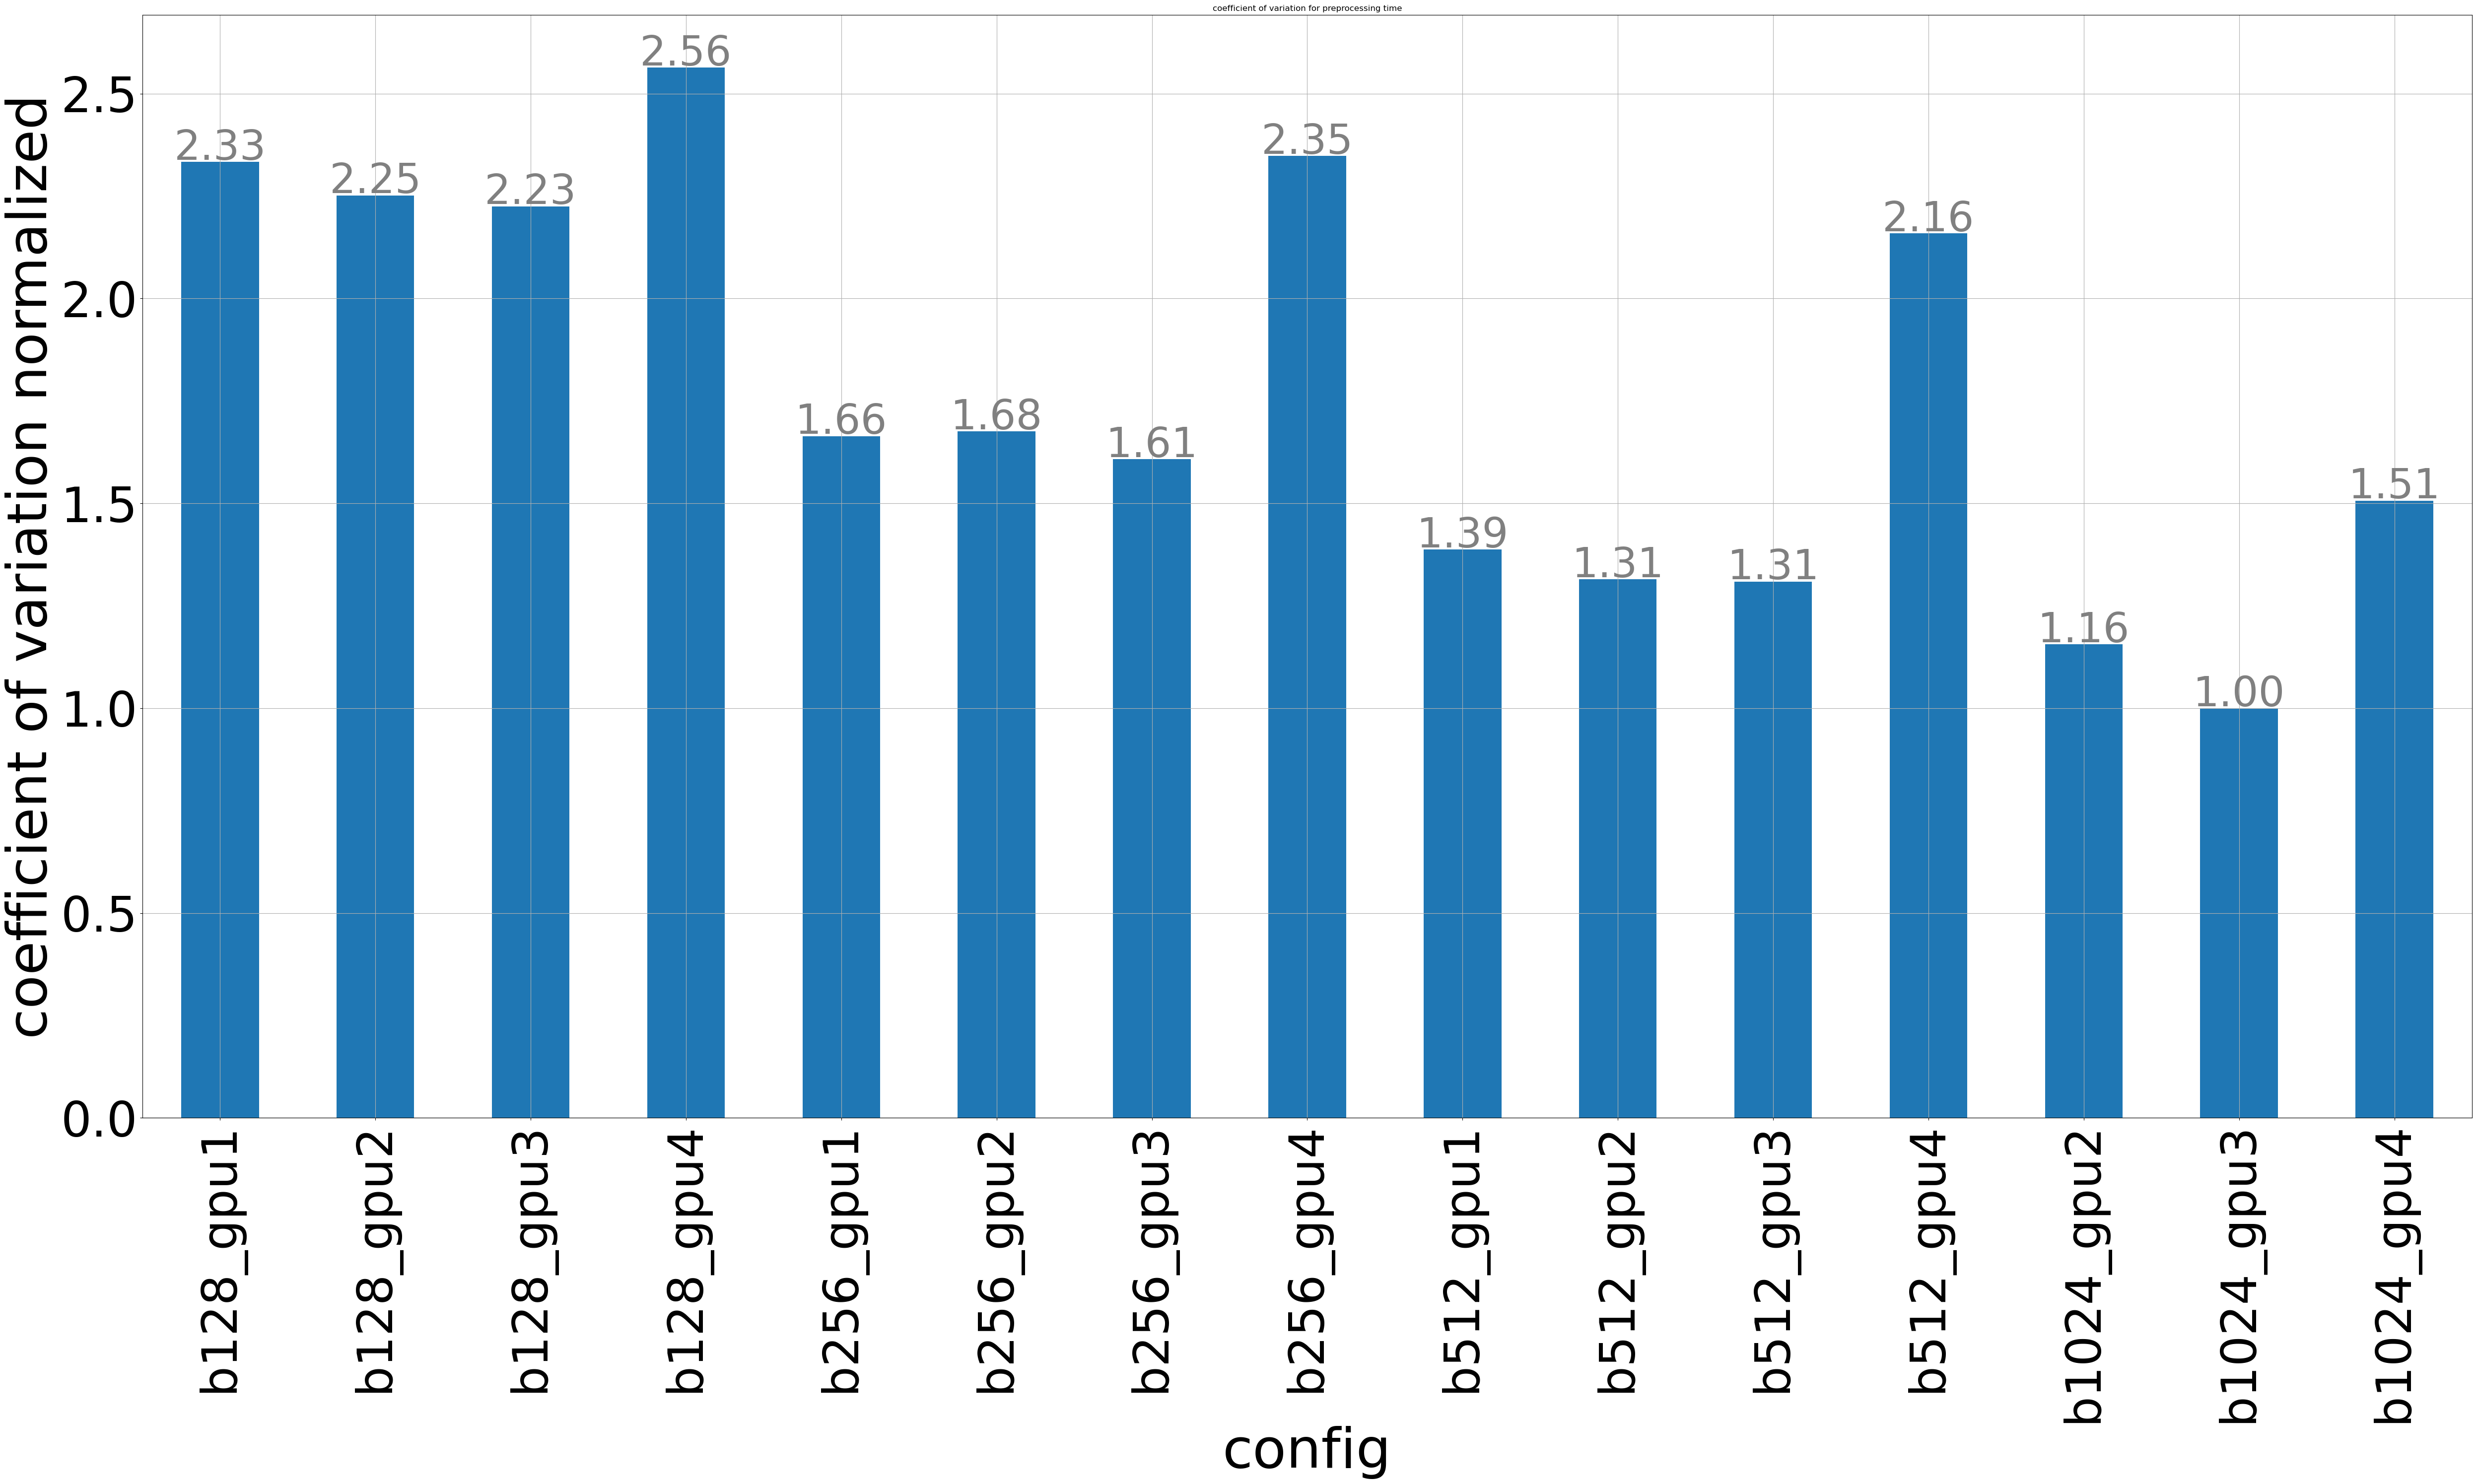

In [10]:
# divide std/avg to get coefficient of variation and normalize it and plot it

coefficient_of_variation = std['std']/avg['avg']

coefficient_of_variation_normalized = coefficient_of_variation/coefficient_of_variation.min()

fig, ax = plt.subplots(figsize=(50,30))
coefficient_of_variation_normalized.plot(kind='bar', ax=ax)
# put numbers on top of bars

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=60, color='gray', xytext=(0, 20),
                textcoords='offset points')
    
ax.set_xlabel('config')
ax.set_ylabel('coefficient of variation normalized')
ax.set_title('coefficient of variation for preprocessing time')
ax.grid(True)
fig.tight_layout()

plt.show()